In [1]:
import numpy as np


class TrafficSimulation:

    def __init__(self, road_length=100, car_density=0.2, prob_slow=0.5,
                 max_speed=5, cross1_index=-1, cross2_index=-1, prob_turn_right=0.5):
        '''
        Create a new traffic simulation object. Cars are distributed randomly
        along the road and start with random velocities.

        Inputs:

            road_length (int) The number of cells in the road. Default: 100.

            car_density (float) The fraction of cells that have a car on them.
              Default: 0.2.

            prob_slow (float) The probability that a car will randomly slow down
              by 1 during an update step. Default: 0.5.

            max_speed (int) The maximum speed in car cells per update step.
              Default: 5.
        '''
        self.road_length = road_length
        self.car_density = car_density
        self.max_speed = max_speed
        self.prob_slow = prob_slow
        # 第一个交叉口的位置
        self.cross1_index = cross1_index
        # 第二个交叉口的位置
        self.cross2_index = cross2_index
        
        # 第一个交叉口的红绿灯状态
        self.cross1_is_green = True
        # 第二个交叉口的红绿灯状态
        self.cross2_is_green = True
        
        # 往右拐弯的可能性
        self.prob_turn_right = prob_turn_right

        # Create an empty road: -1 means empty in this simulation
        self.state = np.full(self.road_length, -1, dtype=int)
        # Choose random locations to place cars except the cross of road
        temp_random_indexes = np.random.choice(
            range(self.road_length - 2),
            size=int(round(car_density * (self.road_length - 2))),
            replace=False)
        temp_random_indexes = np.where(temp_random_indexes >= cross1_index, temp_random_indexes + 1, temp_random_indexes)
        random_indexes = np.where(temp_random_indexes >= cross2_index, temp_random_indexes + 1, temp_random_indexes)
        # Give each car a random initial speed from 0 to max_speed
        self.state[random_indexes] = np.random.randint(
            0, self.max_speed + 1, size=len(random_indexes))

        # Keep track of the time steps and average traffic flow at each step
        self.time_step = 0
        self.average_traffic_flow = []
        self.average_fleet_length = []

    # set the traffic light of the first cross
    def set_cross1(self, is_green):
        self.cross1_is_green = is_green

    # set the traffic light of the second cross
    def set_cross2(self, is_green):
        self.cross2_is_green = is_green

    def update(self):
        '''
        Advance one time step in the simulation.
        '''
        # Get the location of each car
        car_indexes = np.where(self.state >= 0)[0]

        resv = -1
        # If there are no cars, we have nothing to update
        if len(car_indexes) == 0:
            self.average_traffic_flow.append(0)
            self.average_fleet_length.append(0)
            self.time_step += 1
            return resv

        # Get the speed of each cars
        car_speeds = self.state[car_indexes]
        # Get the distance from each car to the next car
        car_distances = np.ediff1d(
            np.concatenate((car_indexes,
                            [car_indexes[0] + self.road_length])))

        # Consider the traffic light situation and adjust the distance between the cars
        # 一个车道有两个交叉口
        cross_count = 2

        # 第二个交叉口前第一个车辆的位置的索引
        cross2_before = -1
        
        # 从最后面的车辆开始循环到最前面的车（前：左边， 后：右边， 车辆驾驶方向：左->右）
        for i in range(len(car_indexes) - 1, -1, -1):
            
            if car_indexes[i] < self.cross1_index and not self.cross1_is_green and cross_count >= 1:
                # 如果第一个交叉口的红绿灯为红灯的话，找出第一个交叉口前的第一辆汽车并修改它的车子之间的距离为到第一个交叉口的距离；车子之间的距离是从这个车辆到下一个车辆之间的距离
                car_distances[i] = self.cross1_index - car_indexes[i]
                cross_count = 0
            elif car_indexes[i] < self.cross2_index and cross_count ==2:
                if not self.cross2_is_green:
                    # 如果第二个交叉口的红绿灯为红灯的话，找出第二个交叉口前的第一辆汽车并修改它的车子之间的距离为到第二个交叉口的距离；车子之间的距离是从这个车辆到下一个车辆之间的距离
                    car_distances[i] = self.cross2_index - car_indexes[i]
                else:
                    # 如果第二个交叉口的红绿灯为绿灯的话， 为往右拐弯准备相关数据
                    cross2_before = i
                cross_count = 1

        # Update car speeds
        # Acceleration
        car_speeds = np.where(
            car_speeds + 1 <= self.max_speed,
            car_speeds + 1,
            self.max_speed)
        # Deceleration
        car_speeds = np.where(
            car_speeds >= car_distances,
            car_distances - 1,
            car_speeds)

        # Randomization slowing speed
        moving_car_indexes = np.where(car_speeds > 0)[0]
        car_speeds[moving_car_indexes] -= (
                np.random.uniform(size=len(moving_car_indexes)) < self.prob_slow)

        if (
                (self.state[i] > 0) and
                (np.random.uniform() < self.prob_slow)
        ):
            self.state[i] -= 1

        # Move cars forward using their new speeds
        car_indexes += car_speeds
        car_indexes %= self.road_length
        self.state.fill(-1)
        self.state[car_indexes] = car_speeds
        # 如果根据拐弯可能性要拐弯的话， 直接设置要拐弯的车辆的速度为-1.这样可以从这个车道中移除这个车辆。然后赋值给resv这个车辆的目前速度。
        if np.random.uniform() < self.prob_turn_right and self.cross2_is_green and car_indexes[cross2_before] >= self.cross2_index :
            resv = car_speeds[cross2_before]
            self.state[car_indexes[cross2_before]] = -1

        # 计算平均车队长度
        afl = 0
        # 从第二个交叉口前一个格子开始计数等待的车辆数
        for i in range(self.cross2_index - 1 , self.cross1_index, -1):
            if self.state[i] == 0:
                afl += 1
            else:
                break

        # 从第一个交叉口前一个格子开始计数等待的车辆数
        i = self.cross1_index - 1
        while True:
            if self.state[i] == 0:
                afl += 1
            else:
                break
            if i == self.cross2_index:
                break
            i -= 1
            if i < 0:
                i = self.road_length - 1

        # Update traffic flow history
        self.average_traffic_flow.append(sum(car_speeds) / self.road_length)
        
        # 更新平均车队长度
        self.average_fleet_length.append(afl)
        self.time_step += 1
        return resv

    def add(self, resv):
        self.state[self.cross1_index] = resv


    def display(self):
        '''
        Print out the current state of the simulation.
        '''
        print(''.join('.' if x == -1 else str(x) for x in self.state))

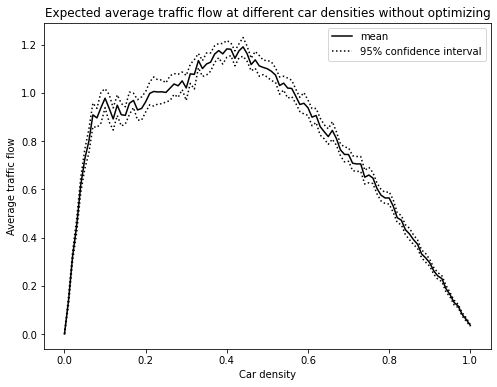

In [1]:
        
# Run the simulation 20 times without optimizing the traffic light system at various traffic densities from 0 to 1 and
# record the results. The maximum speed is 5 and the probability of slowing
# down is 0.5.

trials = 20  # Number of times to repeat the simulation at each density
densities = np.linspace(0, 1, 101)
average_flows = []  # The results go here

for car_density in densities:
    flows = []
    for trial in range(trials):
        # print(trial)
        lighting_time = 5
        crosses_road = [True, True, True, True]
        cross_index = [15, 84]
        road_length = 100
        max_speed = 5
        prob_slow = 0.1
        prob_turn_right = 0.5
        sims = []
        sims.append(TrafficSimulation(
            road_length=road_length, car_density=car_density, max_speed=max_speed, prob_slow=prob_slow,
            cross1_index=cross_index[0]
            , cross2_index=cross_index[1], prob_turn_right=prob_turn_right))
        sims.append(TrafficSimulation(
            road_length=road_length, car_density=car_density, max_speed=max_speed, prob_slow=prob_slow,
            cross1_index=cross_index[0]
            , cross2_index=cross_index[1], prob_turn_right=prob_turn_right))
        sims.append(TrafficSimulation(
            road_length=road_length, car_density=car_density, max_speed=max_speed, prob_slow=prob_slow,
            cross1_index=cross_index[0]
            , cross2_index=cross_index[1], prob_turn_right=prob_turn_right))
        sims.append(TrafficSimulation(
            road_length=road_length, car_density=car_density, max_speed=max_speed, prob_slow=prob_slow,
            cross1_index=cross_index[0]
            , cross2_index=cross_index[1], prob_turn_right=prob_turn_right))

        time_count = 0
        # Run for 50 steps to reach an equilibrium state
        for i in range(50):
            # 每次到了红绿灯时长切换所有交叉口的红绿灯状态
            if (i + 1) % lighting_time == 0:
                for j in range(4):
                    crosses_road[j] = not crosses_road[j]
            # 更新所有交叉口的红绿灯状态
            for j in range(4):
                nextj = (j + 1) % 4
                sims[j].set_cross2(crosses_road[j])
                sims[nextj].set_cross1(not crosses_road[j])
            
            # 更新每个车道
            for j in range(4):
                nextj = (j + 1) % 4
                # 如果下一个车道的这个交叉口处有车辆的话，这个车道上的这个交叉口处设置成红灯状态并阻止碰撞。
                if sims[nextj].state[sims[nextj].cross1_index] != -1:
                    sims[j].set_cross2(False)
                nextj = (j + 1) % 4
                # 获取这个车道的往右拐弯的车辆的速度
                resv = sims[j].update()
                #如果有一个车辆拐弯的话，添加到下一个车道上的这个交叉口处
                if resv > -1:
                    sims[nextj].add(resv)
                # 如果这一个车道的这个交叉口处有车辆的话，下一个车道上的这个交叉口处设置成红灯状态并阻止碰撞。
                if sims[j].state[sims[j].cross2_index] != -1:
                    sims[nextj].set_cross1(False)
        # Record the final average traffic flow
        flows.append(sims[0].average_traffic_flow[-1] + sims[1].average_traffic_flow[-1] + sims[2].average_traffic_flow[-1] + sims[3].average_traffic_flow[-1])
    average_flows.append(flows)
average_flows = np.array(average_flows)

import matplotlib.pyplot as plt
import scipy.stats as sts

plt.figure(figsize=(8, 6))
plt.title('Expected average traffic flow at different car densities without optimizing')
plt.xlabel('Car density')
plt.ylabel('Average traffic flow')
flow_mean = np.mean(average_flows, axis=1)
std_err = sts.sem(average_flows, axis=1)
plt.plot(densities, flow_mean, 'k-', label='mean')
plt.plot(densities, flow_mean - 1.96 * std_err, 'k:',
         label='95% confidence interval')
plt.plot(densities, flow_mean + 1.96 * std_err, 'k:')
plt.legend()
plt.show()

In [ ]:
# Run the simulation 20 times with optimizing the traffic light system at various traffic densities from 0 to 1 and
# record the results. The maximum speed is 5 and the probability of slowing
# down is 0.5.



trials = 20  # Number of times to repeat the simulation at each density
densities = np.linspace(0, 1, 101)
average_flows = []  # The results go here

for car_density in densities:
    flows = []
    for trial in range(trials):
        cross_index = [15, 84]
        road_length = 100
        max_speed = 5
        prob_slow = 0.1
        prob_turn_right = 0.5
        sims = []
        sims.append(TrafficSimulation(
            road_length=road_length, car_density=car_density, max_speed=max_speed, prob_slow=prob_slow,
            cross1_index=cross_index[0]
            , cross2_index=cross_index[1], prob_turn_right=prob_turn_right))
        sims.append(TrafficSimulation(
            road_length=road_length, car_density=car_density, max_speed=max_speed, prob_slow=prob_slow,
            cross1_index=cross_index[0]
            , cross2_index=cross_index[1], prob_turn_right=prob_turn_right))
        sims.append(TrafficSimulation(
            road_length=road_length, car_density=car_density, max_speed=max_speed, prob_slow=prob_slow,
            cross1_index=cross_index[0]
            , cross2_index=cross_index[1], prob_turn_right=prob_turn_right))
        sims.append(TrafficSimulation(
            road_length=road_length, car_density=car_density, max_speed=max_speed, prob_slow=prob_slow,
            cross1_index=cross_index[0]
            , cross2_index=cross_index[1], prob_turn_right=prob_turn_right))

        time_count = 0
        # Run for 50 steps to reach an equilibrium state
        for i in range(50):

            for j in range(4):
                nextj = (j + 1) % 4
                # 优化交叉口的红绿灯，有车辆等待的车道上的交叉口处设置成绿灯。如果没有的话优先是这个车道而不是下一个车道。这样做是因为这个车道在第二个交叉口处可以直行也可以分散车辆
                if sims[j].state[sims[j].cross2_index - 1] != -1:
                    sims[j].set_cross2(True)
                    sims[nextj].set_cross1(False)
                elif sims[nextj].state[sims[nextj].cross1_index - 1] != -1:
                    sims[j].set_cross2(False)
                    sims[nextj].set_cross1(True)
                else:
                    sims[j].set_cross2(True)
                    sims[nextj].set_cross1(False)
            for j in range(4):
                nextj = (j + 1) % 4
                if sims[nextj].state[sims[nextj].cross1_index] != -1:
                    sims[j].set_cross2(False)
                nextj = (j + 1) % 4
                resv = sims[j].update()
                if resv > -1:
                    sims[nextj].add(resv)
                if sims[j].state[sims[j].cross2_index] != -1:
                    sims[nextj].set_cross1(False)
        # Record the final average traffic flow
        flows.append(sims[0].average_traffic_flow[-1] + sims[1].average_traffic_flow[-1] + sims[2].average_traffic_flow[-1] + sims[3].average_traffic_flow[-1])
    average_flows.append(flows)
average_flows = np.array(average_flows)

import matplotlib.pyplot as plt
import scipy.stats as sts

plt.figure(figsize=(8, 6))
plt.title('Expected average traffic flow at different car densities with optimizing')
plt.xlabel('Car density')
plt.ylabel('Average traffic flow')
flow_mean = np.mean(average_flows, axis=1)
std_err = sts.sem(average_flows, axis=1)
plt.plot(densities, flow_mean, 'k-', label='mean')
plt.plot(densities, flow_mean - 1.96 * std_err, 'k:',
         label='95% confidence interval')
plt.plot(densities, flow_mean + 1.96 * std_err, 'k:')
plt.legend()
plt.show()

In [ ]:

# Run the simulation 20 times at various traffic lighting times from 1 to 100 and
# record the results. The maximum speed is 5 and the probability of slowing
# down is 0.5. probability of turning right is 0.5. density of cars is 0.5



trials = 20  # Number of times to repeat the simulation at each density
lighting_times = np.linspace(1, 100, 100)
average_fleets = []  # The results go here
car_density = 0.1

for lti in lighting_times:
    fleets = []
    for trial in range(trials):
        # print(trial)
        lighting_time = int(lti)
        crosses_road = [True, True, True, True]
        cross_index = [15, 84]
        road_length = 100
        max_speed = 5
        prob_slow = 0.1
        prob_turn_right = 0.5
        sims = []
        sims.append(TrafficSimulation(
            road_length=road_length, car_density=car_density, max_speed=max_speed, prob_slow=prob_slow,
            cross1_index=cross_index[0]
            , cross2_index=cross_index[1], prob_turn_right=prob_turn_right))
        sims.append(TrafficSimulation(
            road_length=road_length, car_density=car_density, max_speed=max_speed, prob_slow=prob_slow,
            cross1_index=cross_index[0]
            , cross2_index=cross_index[1], prob_turn_right=prob_turn_right))
        sims.append(TrafficSimulation(
            road_length=road_length, car_density=car_density, max_speed=max_speed, prob_slow=prob_slow,
            cross1_index=cross_index[0]
            , cross2_index=cross_index[1], prob_turn_right=prob_turn_right))
        sims.append(TrafficSimulation(
            road_length=road_length, car_density=car_density, max_speed=max_speed, prob_slow=prob_slow,
            cross1_index=cross_index[0]
            , cross2_index=cross_index[1], prob_turn_right=prob_turn_right))

        time_count = 0
        # Run for 50 steps to reach an equilibrium state
        for i in range(50):
            if (i + 1) % lighting_time == 0:
                for j in range(4):
                    crosses_road[j] = not crosses_road[j]

            for j in range(4):
                nextj = (j + 1) % 4
                sims[j].set_cross2(crosses_road[j])
                sims[nextj].set_cross1(not crosses_road[j])
            for j in range(4):
                nextj = (j + 1) % 4
                if sims[nextj].state[sims[nextj].cross1_index] != -1:
                    sims[j].set_cross2(False)
                nextj = (j + 1) % 4
                resv = sims[j].update()
                if resv > -1:
                    sims[nextj].add(resv)
                if sims[j].state[sims[j].cross2_index] != -1:
                    sims[nextj].set_cross1(False)
        # Record the final average traffic flow
        fleets.append(sims[0].average_fleet_length[-1] + sims[1].average_fleet_length[-1] + sims[2].average_fleet_length[-1] + sims[3].average_fleet_length[-1])
    average_fleets.append(fleets)
average_fleets = np.array(average_fleets)

import matplotlib.pyplot as plt
import scipy.stats as sts

plt.figure(figsize=(8, 6))
plt.title('Expected average Average fleet length of waiting cars at different traffic lighting time')
plt.xlabel('lighting time')
plt.ylabel('Average fleet length')
fleet_mean = np.mean(average_fleets, axis=1)
std_err = sts.sem(average_fleets, axis=1)
plt.plot(lighting_times, fleet_mean, 'k-', label='mean')
plt.plot(lighting_times, fleet_mean - 1.96 * std_err, 'k:',
         label='95% confidence interval')
plt.plot(lighting_times, fleet_mean + 1.96 * std_err, 'k:')
plt.legend()
plt.show()
